In [1]:
import tensorflow as tf
tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
import argparse
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras 
from imutils import paths
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from model_mobile import get_model

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [11]:
DATA_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/selected_frames/'
MODEL_DIR = 'C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models'
FOLD = 0
LR = 1e-4
EPOCHS = 50
BATCH_SIZE = 16
TRAINABLE_BASE_LAYERS = 1
IMG_WIDTH, IMG_HEIGHT = (224,224)

In [14]:

model_name = 'pocus_fold_{0}'
plot_path = 'pocus_fold_{0}'

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

# # grab the list of images in our dataset directory, then initialize
# # the list of data (i.e., images) and class images
# print('Loading images...')
# imagePaths = list(paths.list_images(DATA_DIR))
# data = []
# labels = []

# print(f'Model is called : {model_name}')
# print(f'selected fold: {FOLD}')

# train_labels, test_labels = [], []
# train_data, test_data = [], []

Loading images...
Model is called : pocus_fold_{0}
selected fold: 0


In [ ]:
train_val_test={}
label_dict = {'cov':'covid','reg':'regular','pneu':'pneumonia'}
for test_train_dir in os.listdir(DATA_DIR):
    #print(test_train_dir)
    save_image_dir_foldwide = os.path.join(DATA_DIR,test_train_dir)
    label_flod={}
    # label_flod.append(test_train_dir)
    for key,label_folder in label_dict.items():
        print(label_folder)
        fold_path = os.path.join(save_image_dir_foldwide,label_folder)
        print(len(os.listdir(fold_path)))
        # label_flod.append(os.listdir(fold_path))
        label_flod[key]=[os.path.join(fold_path, f) for f in os.listdir(fold_path)] #os.listdir(fold_path)
    train_val_test[test_train_dir] = label_flod

In [ ]:
train_folders=['train_test_1','train_test_2','train_test_3']
val_folders=['train_test_4']
test_folders=['train_test_5']
train_path=[]
train_data=[]
train_labels=[]
val_path=[]
val_data=[]
val_labels=[]
test_path=[]
test_data=[]
test_labels=[]
for path_key,folder in train_val_test.items():
    print(path_key)
    for type_key,paths in folder.items():
        print(type_key)
        print(len(paths))
        if (path_key in train_folders):
           train_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                train_labels.append(type_key)
                train_data.append(image)                      
        if (path_key in val_folders):
           val_path+= paths
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                val_labels.append(type_key)
                val_data.append(image)             
        if (path_key in test_folders):
           test_path+= paths   
           for imagePath in paths:
                image_org = np.load(imagePath,allow_pickle=False)
                assert image_org.shape[0] == 3
                image=np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT,image_org.shape[0])).astype(image_org.dtype)
                for i in range(len(image_org)):
                    # image[i] = cv2.cvtColor(image[i], cv2.COLOR_BGR2RGB)  
                    image[:,:,i] = cv2.resize(cv2.cvtColor(image_org[i], cv2.COLOR_BGR2GRAY), (IMG_WIDTH, IMG_HEIGHT)) 
                test_labels.append(type_key)
                test_data.append(image)                     

print(
    '\nNumber of training samples: '+str(len(train_labels))+' \n'
    'Number of testing samples: '+str(len(test_labels))+''
)

train_data = np.array(train_data)
test_data = np.array(test_data)
val_data = np.array(val_data)

In [26]:
# for imagePath in imagePaths:
#     path_parts = imagePath.split(os.path.sep)
#     # extract the split
#     train_test = path_parts[-3][-1]
#     # extract the class label from the filename
#     label = path_parts[-2]
#     # load the image, swap color channels, and resize it to be a fixed
#     # 224x224 pixels while ignoring aspect ratio
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

#     # update the data and labels lists, respectively
#     if train_test == str(FOLD+1):
#         test_labels.append(label)
#         test_data.append(image)
#     else:
#         train_labels.append(label)
#         train_data.append(image)



In [27]:
len(test_labels)

562

In [28]:

assert len(set(train_labels)) == len(set(test_labels)), (
    'Something went wrong. Some classes are only in train or test data.'
)  # yapf: disable

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
train_data = np.array(train_data) / 255.0
test_data = np.array(test_data) / 255.0
train_labels_text = np.array(train_labels)
test_labels_text = np.array(test_labels)

num_classes = len(set(train_labels))

# perform one-hot encoding on the labels
lb = LabelBinarizer()
lb.fit(train_labels_text)

train_labels = lb.transform(train_labels_text)
test_labels = lb.transform(test_labels_text)

In [29]:

if num_classes == 2:
    train_labels = to_categorical(train_labels, num_classes=num_classes)
    test_labels = to_categorical(test_labels, num_classes=num_classes)

trainX = train_data
trainY = train_labels
testX = test_data
testY = test_labels
print('Class mappings are:', lb.classes_)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Load the VGG16 network
model = get_model(
    input_size=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes
)

Class mappings are: ['covid' 'pneumonia' 'regular']
19993432/19993432 [==============================] - 7s 0us/step


In [31]:
num_layers = len(model.layers)
num_layers

776

In [37]:
from keras.metrics import Metric
# Number of layers in model head (fresh weights), this is fixed in get_model.
#num_head_layers =30
# Freeze all VGG layers apart from the last layers (TRAINABLE_BASE_LAYERS)
#num_layers = len(model.layers)
#for ind, layer in enumerate(model.layers):
#    if ind < num_layers - num_head_layers - TRAINABLE_BASE_LAYERS:
#        layer.trainable = False

# Define callbacks
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

mcp_save = ModelCheckpoint(
    os.path.join(MODEL_DIR, 'fold_' + str(FOLD) + '_epoch_{epoch:02d}'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    verbose=1,
    epsilon=1e-4,
    mode='min'
)
# To show balanced accuracy
# metrics = Metric((testX, testY), model)

# compile model
print('Compiling model...')
opt = Adam(lr=LR, decay=LR / EPOCHS)
model.compile(
    loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']
)

print('Model has {model.count_params()} parameters')
print('Model summary {model.summary()}')
model.summary()

Compiling model...
Model has {model.count_params()} parameters
Model summary {model.summary()}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 32  128         ['stem_conv1[0][0]']             

c:\Users\212733771\AppData\Local\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 adjust_relu_1_stem_2 (Activati  (None, 111, 111, 32  0          ['stem_bn1[0][0]']               
 on)                            )                                                                 
                                                                                                  
 reduction_add_2_stem_1 (Add)   (None, 56, 56, 11)   0           ['reduction_left2_stem_1[0][0]', 
                                                                  'separable_conv_2_bn_reduction_r
                                                                 ight2_stem_1[0][0]']             
                                                                                                  
 reduction_left3_stem_1 (Averag  (None, 56, 56, 11)  0           ['reduction_pad_1_stem_1[0][0]'] 
 ePooling2D)                                                                                      
                                                                                                  
 separable

In [38]:

# train the head of the network
print('Starting training model...')
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    steps_per_epoch=len(trainX) // BATCH_SIZE,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=BATCH_SIZE)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)


Starting training model...


C:\Users\212733771\AppData\Local\Temp\ipykernel_6712\3400543215.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/50
826/826 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9546WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 35 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_accuracy improved from -inf to 0.96263, saving model to C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01


INFO:tensorflow:Assets written to: C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01\assets


INFO:tensorflow:Assets written to: C:/Users/212733771/Documents/Covid-Ultrasound/mobilenet_models\fold_0_epoch_01\assets


826/826 [==============================] - 1012s 1s/step - loss: 0.1259 - accuracy: 0.9546 - val_loss: 0.1959 - val_accuracy: 0.9626 - lr: 1.0000e-04
Epoch 2/50
826/826 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9965WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 845s 1s/step - loss: 0.0170 - accuracy: 0.9965 - lr: 1.0000e-04
Epoch 3/50
826/826 [==============================] - ETA: 0s - loss: 0.0134 - accuracy: 0.9972WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 854s 1s/step - loss: 0.0134 - accuracy: 0.9972 - lr: 1.0000e-04
Epoch 4/50
826/826 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9981WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 790s 955ms/step - loss: 0.0101 - accuracy: 0.9981 - lr: 1.0000e-04
Epoch 5/50
826/826 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9982WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 840s 1s/step - loss: 0.0100 - accuracy: 0.9982 - lr: 1.0000e-04
Epoch 6/50
826/826 [==============================] - ETA: 0s - loss: 0.0061 - accuracy: 0.9986WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 824s 997ms/step - loss: 0.0061 - accuracy: 0.9986 - lr: 1.0000e-04
Epoch 7/50
826/826 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9997WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 830s 1s/step - loss: 0.0027 - accuracy: 0.9997 - lr: 1.0000e-04
Epoch 8/50
826/826 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9983WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 822s 995ms/step - loss: 0.0068 - accuracy: 0.9983 - lr: 1.0000e-04
Epoch 9/50
826/826 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9988WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 817s 989ms/step - loss: 0.0048 - accuracy: 0.9988 - lr: 1.0000e-04
Epoch 10/50
826/826 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.9995WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 819s 991ms/step - loss: 0.0027 - accuracy: 0.9995 - lr: 1.0000e-04
Epoch 11/50
826/826 [==============================] - ETA: 0s - loss: 0.0084 - accuracy: 0.9983WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 821s 993ms/step - loss: 0.0084 - accuracy: 0.9983 - lr: 1.0000e-04
Epoch 12/50
826/826 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9992WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 822s 995ms/step - loss: 0.0032 - accuracy: 0.9992 - lr: 1.0000e-04
Epoch 13/50
826/826 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9985WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 818s 990ms/step - loss: 0.0073 - accuracy: 0.9985 - lr: 1.0000e-04
Epoch 14/50
826/826 [==============================] - ETA: 0s - loss: 9.2104e-04 - accuracy: 0.9999WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


826/826 [==============================] - 820s 992ms/step - loss: 9.2104e-04 - accuracy: 0.9999 - lr: 1.0000e-04
Epoch 15/50
103/826 [==>...........................] - ETA: 12:12 - loss: 3.3333e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [12]:
print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs, target_names=lb.classes_
    )
)

classification report sklearn:
              precision    recall  f1-score   support

       covid       0.87      1.00      0.93       232
   pneumonia       1.00      0.52      0.68       116
     regular       0.45      0.57      0.51        80

    accuracy                           0.79       428
   macro avg       0.77      0.70      0.71       428
weighted avg       0.83      0.79      0.78       428



confusion matrix:
[[232   0   0]
 [  0  60  56]
 [ 34   0  46]]
Saving COVID-19 detector model on {model_name} data...
Done, shuttting down!


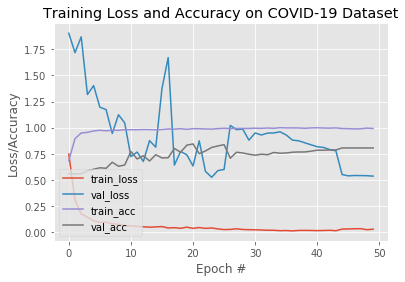

In [13]:
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

# serialize the model to disk
print('Saving COVID-19 detector model on {model_name} data...')
model.save(os.path.join(MODEL_DIR, model_name), save_format='h5')

# plot the training loss and accuracy
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), H.history['loss'], label='train_loss')
plt.plot(np.arange(0, N), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, N), H.history['accuracy'], label='train_acc')
plt.plot(np.arange(0, N), H.history['val_accuracy'], label='val_acc')
plt.title('Training Loss and Accuracy on COVID-19 Dataset')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc='lower left')
plt.savefig(os.path.join(MODEL_DIR, plot_path))

print('Done, shuttting down!')
